In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('merged_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head()

,Game_date,Games_played_to_date,BA,PA,Name,ISO,SLG,BABIP,BIP,OBP,...,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,next_game_team1,next_game_team2,hitter_R%,hitter_L%,next_game_hit_vs_fp
0,2014-03-31,1,0.00000,4,Travis d'Arnaud,0.0,0.00000,0.00000,0.33333,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
1,2014-03-31,1,0.20000,5,Jayson Werth,0.0,0.20000,0.33333,0.60000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
2,2014-03-31,1,0.25000,5,Ian Desmond,0.0,0.25000,0.25000,1.00000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
3,2014-03-31,1,0.25000,5,Bryce Harper,0.0,0.25000,0.50000,0.50000,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
4,2014-03-31,1,0.33333,5,Adam LaRoche,1.0,1.33333,0.00000,1.00000,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1


In [3]:
train = df[["PA","BA","pHitsByZone3", "hitter_R%", "BIP", "BABIP", "LA_median", "Weather (Degrees)", "Wind (MPH)", "Area_stand", 
            "Altitude", "H", "RUNS", "pitches_per_appearance_avg", "strikeout_percentage", "hip_last_three", 
            "ground_ball_percentage", "Strikes_Swinging"]]
test = df[['next_game_HIT']]

In [4]:
for i in train.columns:    
    if (train.shape[0] - train[i].count()) / train.shape[0] > .3:
        print (i)
        train = train.drop([i], axis = 1)

pHitsByZone3


In [5]:
for i in train.columns:
    if len(train[i].unique()) > 2:
        train[i] = train[i].fillna(train[i].median())
    else:
        train[i] = train[i].fillna(train[i].mode()[0])

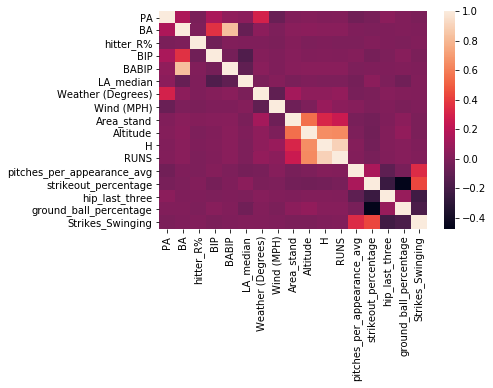

In [6]:
corr = train.corr()
sns.heatmap(corr)

In [7]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.20, shuffle = False)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(solver = 'sag', max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.638722294654498
[0.64857161 0.64747036 0.64805338 0.64805338 0.64809536 0.64796579
 0.6491319  0.64841928 0.64783623 0.64770666]


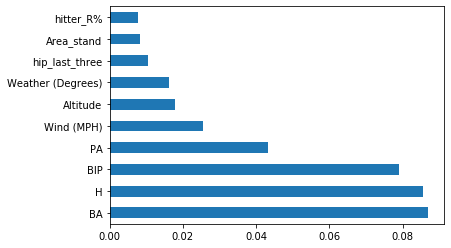

In [10]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

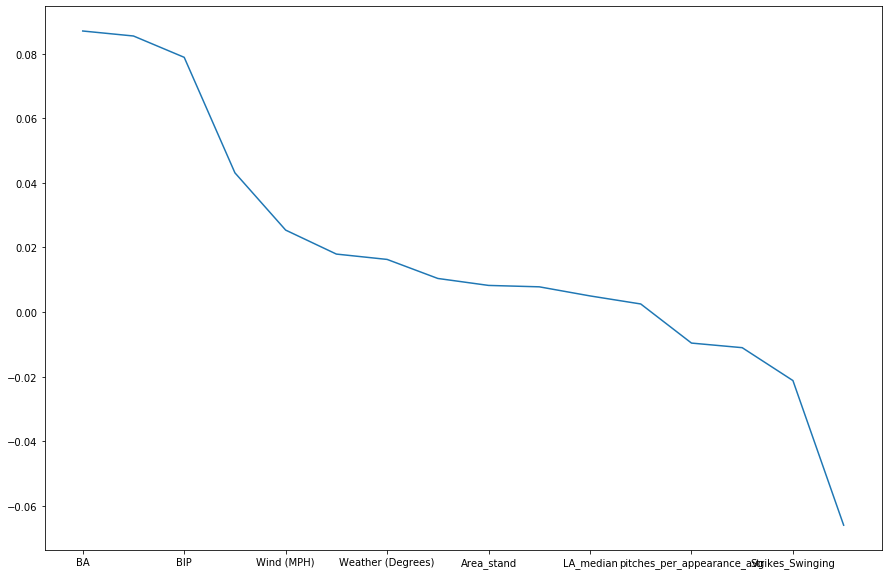

In [11]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(loss="log", max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.6396958214924745
[0.64727603 0.64494397 0.64695213 0.64053896 0.64770666 0.64297746
 0.63811868 0.6463462  0.64369008 0.64472661]


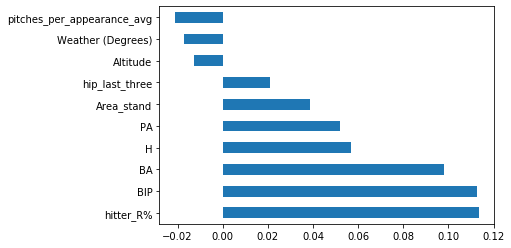

In [13]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

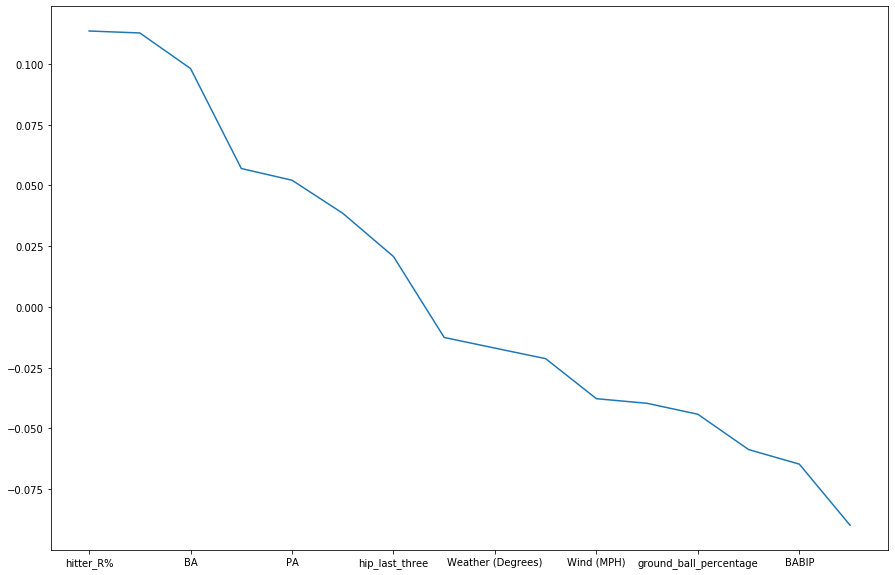

In [14]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.6461842581507364


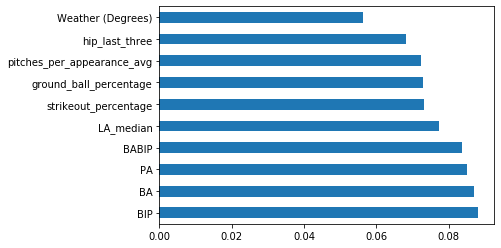

In [16]:
feat_importances = pd.Series(clf.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

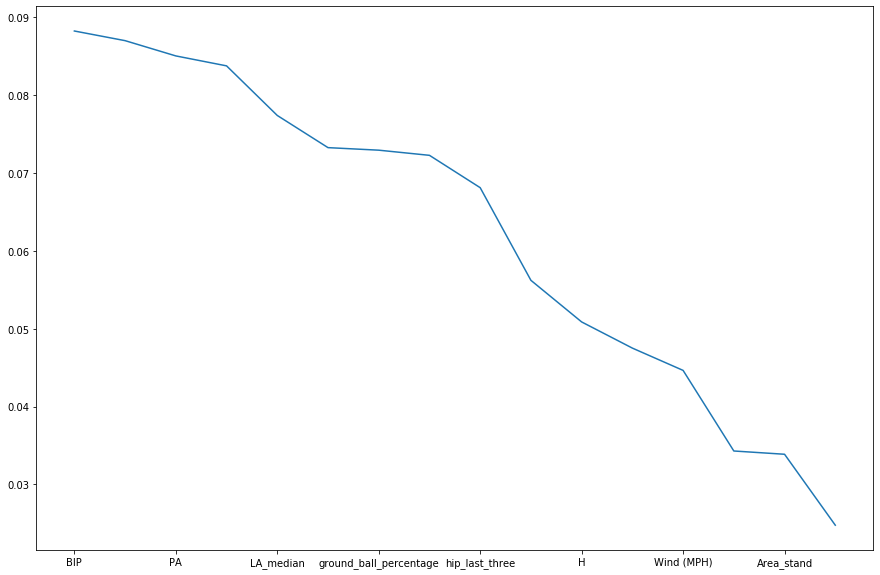

In [17]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (15, 10))

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score

clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.638450913450262


In [19]:
train = train.join(df['Name'])
train = train.join(df['next_game_HIT'])
names = train['Name'].unique().tolist()
temp = train['Name'].value_counts().to_frame()
temp = temp.reset_index()
temp.columns = ['Name', 'Count']
for i in range(len(temp)):
    if temp.at[i, 'Count'] < 30:
        names.remove(temp.at[i, 'Name'])

In [20]:
len(df['Name'].unique()) - len(names)

300

In [21]:
len(names) / len(df['Name'].unique()) 

0.7169811320754716

In [22]:
players = pd.DataFrame()

count = 0

for name in names:
    
    players.at[count, 'Name'] = name
    
    train2 = train[train['Name'] == name]
    train2 = train2.drop(['Name'], axis = 1)
    test2 = train2['next_game_HIT']
    train2 = train2.drop(['next_game_HIT'], axis = 1)
    
    players.at[count, 'Samples'] = train2.shape[0]
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    X_train, X_test, y_train, y_test = train_test_split(train2, test2, test_size = 0.20, shuffle = False)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score
    
    clf = LogisticRegression(solver = 'sag', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'LR'] = precision_score(y_test, predictions)
    
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import precision_score
    
    clf = SGDClassifier(loss = 'log', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'SGD'] = precision_score(y_test, predictions)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_score
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'RF'] = precision_score(y_test, predictions) 
    
    count += 1
               
players.head()

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precis

,Name,Samples,LR,SGD,RF
0,Travis d'Arnaud,365.0,0.703704,0.714286,0.724138
1,Jayson Werth,376.0,0.611111,0.640000,0.587302
2,Ian Desmond,649.0,0.658730,0.635417,0.689320
3,Bryce Harper,728.0,0.623288,0.591549,0.641221
4,Adam LaRoche,198.0,0.638889,0.666667,0.645161


In [23]:
print ('LR: ' + str(players['LR'].mean()))
print ('LR: ' + str(players['SGD'].mean()))
print ('RF: ' + str(players['RF'].mean()))

LR: 0.618181755974967
LR: 0.6159536430206939
RF: 0.6144831501433209
